# set up

In [1]:
import pandas as pd
import numpy as np
import mygene as mygene
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import json

In [20]:
from sklearn.preprocessing import StandardScaler
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from pydeseq2.preprocessing import deseq2_norm
from pydeseq2.utils import load_example_data
import scipy
import umap.umap_ as umap

# 1b 
## switching from ensemble to hugo

In [3]:
#Load the TSV file into a DataFrame
df = pd.read_csv("SRP158491/SRP158491.tsv", sep='\t')

nan_genes_before = df['Gene'].isna().sum()
total_genes_before = len(df['Gene'])

mg = mygene.MyGeneInfo()
query_result = mg.querymany(df['Gene'].tolist(), scopes='ensembl.gene',
                           fields='symbol', species='human')
ensembl_to_hugo = {item['query']: item.get('symbol', '') for item in query_result}
df['Gene'] = df['Gene'].map(ensembl_to_hugo)

df = df.drop_duplicates(subset='Gene', keep='first')
df.to_csv('SRP158491_converted.tsv', sep='\t', index=False)

6 input query terms found dup hits:	[('ENSG00000188660', 2), ('ENSG00000249738', 2), ('ENSG00000268674', 3), ('ENSG00000273730', 10), ('
447 input query terms found no hit:	['ENSG00000112096', 'ENSG00000116883', 'ENSG00000130489', 'ENSG00000130723', 'ENSG00000137808', 'ENS


# 1c
## expression matrix size? num genes? how much variation?

In [4]:
df = pd.read_csv("SRP158491_converted.tsv", sep='\t')

#expression matrix
matrixSize = df.shape

#num genes
numGenes = df['Gene'].nunique()


logSclDf = df.copy()
logSclDf.iloc[:,1:] = np.log1p(df.iloc[:,1:])

#calculate per gene median expression ranges
medExprRate = logSclDf.iloc[:, 1:].median(axis = 1)

print(f"Expression matrix size: {matrixSize}")
print(f"Number of genes: {numGenes}")

Expression matrix size: (31645, 277)
Number of genes: 31644


## making the density plot

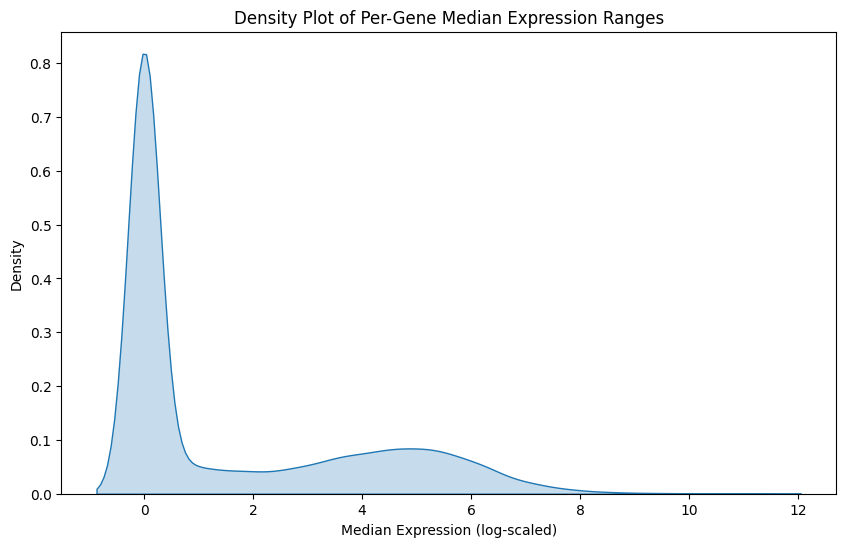

In [5]:
# Create a density plot of the median expression ranges
plt.figure(figsize=(10, 6))
sns.kdeplot(medExprRate, fill=True)
plt.title("Density Plot of Per-Gene Median Expression Ranges")
plt.xlabel("Median Expression (log-scaled)")
plt.ylabel("Density")
plt.savefig("median_expression_density_plot.png")
plt.show()

In [6]:
summary = f"""
Expression matrix size: {matrixSize}
Number of genes: {numGenes}
Median expression ranges: {medExprRate.max() - medExprRate.min()}
Mean: {medExprRate.mean()}
Standard Deviation: {medExprRate.std()}
"""

print(summary)

# Save the summary to a text file
with open("summary.txt", "w") as file:
    file.write(summary)


Expression matrix size: (31645, 277)
Number of genes: 31644
Median expression ranges: 11.18485782302886
Mean: 1.6208138288935288
Standard Deviation: 2.311444972676422



# 2a

## separate healthy vs unhealthy data

In [7]:
with open('SRP158491/aggregated_metadata.json') as file:
    data = json.load(file)

## gather the indices of the specific patient types

In [8]:
healthy_indices = ['Gene']
rheumatoid_indices = ['Gene']
ifx_indices = ['Gene']
mtx_indices = ['Gene']
no_trt_indices = ['Gene']
tcz_indices = ['Gene']
synovial_indices = ['Gene']
for column in df.columns:
    if(column == 'Gene'):
        continue
    elif data['samples'][column]['refinebio_disease'] == 'healthy':
        healthy_indices.append(column)
    elif data['samples'][column]['refinebio_disease'] == 'ra ifx treatment':
        rheumatoid_indices.append(column)
        ifx_indices.append(column)
    elif data['samples'][column]['refinebio_disease'] == 'ra mtx treatment':
        rheumatoid_indices.append(column)
        mtx_indices.append(column)
    elif data['samples'][column]['refinebio_disease'] == 'ra non treatment':
        rheumatoid_indices.append(column)
        no_trt_indices.append(column)
    elif data['samples'][column]['refinebio_disease'] == 'ra tcz treatment':
        rheumatoid_indices.append(column)
        tcz_indices.append(column)
    else:
        rheumatoid_indices.append(column)
        synovial_indices.append(column)

## make separate df for each patient category

In [9]:
healthy_df = logSclDf[healthy_indices]
rheumatoid_df = logSclDf[rheumatoid_indices]
ifx_df = logSclDf[ifx_indices]
mtx_df = logSclDf[mtx_indices]
no_trt_df = logSclDf[no_trt_indices]
tcz_df = logSclDf[tcz_indices]
synovial_df = logSclDf[synovial_indices]

In [10]:
pca = PCA(n_components=2)
pca.fit(logSclDf.iloc[:, 1:].transpose())

PCA(n_components=2)

## making the varieties of non-healthy patients' df come from the log scaled df

In [11]:
rheumatoid_df = logSclDf[rheumatoid_indices]
ifx_df = logSclDf[ifx_indices]
mtx_df = logSclDf[mtx_indices]
no_trt_df = logSclDf[no_trt_indices]
tcz_df = logSclDf[tcz_indices]
synovial_df = logSclDf[synovial_indices]

## transposing each df bc pca expects rows to be the individuals and the genes as the columns

In [12]:
healthy_pca = pca.transform(healthy_df.iloc[:, 1:].transpose())
rheumatoid_pca = pca.transform(rheumatoid_df.iloc[:, 1:].transpose())
ifx_pca = pca.transform(ifx_df.iloc[:, 1:].transpose())
mtx_pca = pca.transform(mtx_df.iloc[:, 1:].transpose())
no_trt_pca = pca.transform(no_trt_df.iloc[:, 1:].transpose())
tcz_pca = pca.transform(tcz_df.iloc[:, 1:].transpose())
synovial_pca = pca.transform(synovial_df.iloc[:, 1:].transpose())

# 2b and c

Text(0.5, 1.0, 'Healthy and Non-Treated RA Individuals PCA')

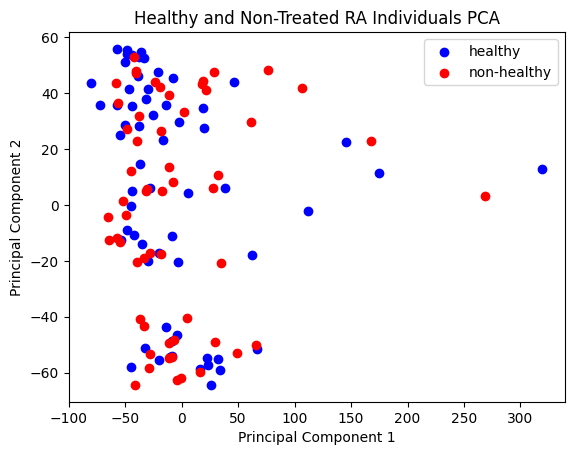

In [13]:
plt.scatter(healthy_pca[:, 0], healthy_pca[:, 1], c='blue', label='healthy')
plt.scatter(no_trt_pca[:, 0], no_trt_pca[:, 1], c='red', label='non-healthy')
plt.legend()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Healthy and Non-Treated RA Individuals PCA')

# 2di

## t-SNE plot

In [14]:
from sklearn.manifold import TSNE

## use T-SNE to take in the log scaled df

In [15]:
tsne = TSNE(n_components=2).fit_transform(logSclDf.iloc[:, 1:].transpose())

## create the df to use for this t-sne plot

In [16]:
tsne_df = pd.DataFrame(data = tsne, index=logSclDf.iloc[:, 1:].transpose().index)

## create the plot

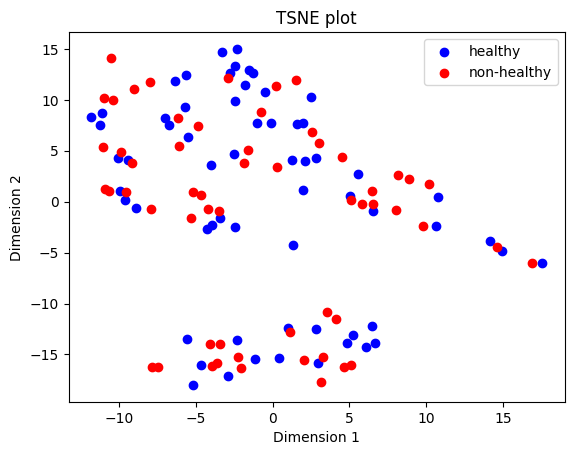

In [18]:
plt.scatter(tsne_df.loc[healthy_indices[1:]][0], tsne_df.loc[healthy_indices[1:]][1], c = 'blue', label='healthy')
plt.scatter(tsne_df.loc[no_trt_indices[1:]][0], tsne_df.loc[no_trt_indices[1:]][1], c = 'red', label = 'non-healthy')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('TSNE plot')
plt.legend()

# 2d ii

In [21]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(logSclDf.iloc[:, 1:].transpose())

In [22]:
umap_df = pd.DataFrame(data = embedding, index=logSclDf.iloc[:, 1:].transpose().index)

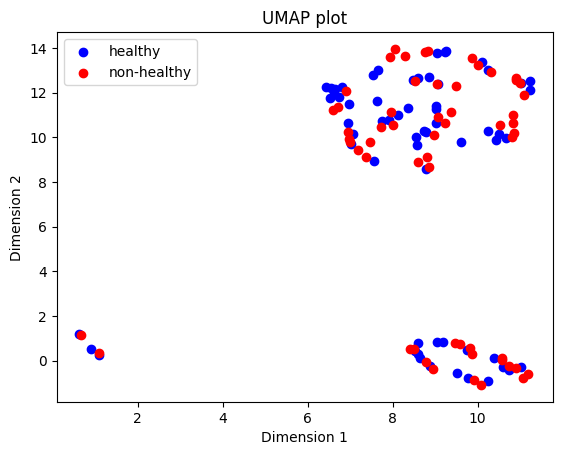

In [24]:
plt.scatter(umap_df.loc[healthy_indices[1:]][0], umap_df.loc[healthy_indices[1:]][1], c = 'blue', label='healthy')
plt.scatter(umap_df.loc[no_trt_indices[1:]][0], umap_df.loc[no_trt_indices[1:]][1], c = 'red', label = 'non-healthy')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('UMAP plot')
plt.legend()

# 3b

In [25]:
metadata_df = pd.read_csv('SRP158491/metadata_SRP158491.tsv', sep='\t')

In [26]:
metadata_df_healthy = metadata_df.loc[metadata_df['refinebio_disease'] == 'healthy']
metadata_df_unhealthy = metadata_df.loc[metadata_df['refinebio_disease'] == 'ra non treatment']

In [27]:
metadata_df = pd.concat([metadata_df_healthy, metadata_df_unhealthy])

In [28]:
deseq_df = df.set_index('Gene')

In [29]:
deseq_df = deseq_df.round(0)

In [30]:
deseq_df = deseq_df.astype(int)

In [31]:
deseq_df.transpose()

Gene,TSPAN6,TNMD,DPM1,SCYL3,FIRRM,FGR,CFH,FUCA2,GCLC,NFYA,...,LOC728392,CPLANE1-AS1,COPG2IT1,LINC00279,NOTCH2NLC,LOC128092249,ARMCX5-GPRASP2,LOC112268419,LOC124903324,LOC114841035
SRR7725764,3,0,68,78,19,3,4,44,256,208,...,115,0,0,0,385,0,0,0,0,0
SRR7725765,5,0,132,42,24,785,23,32,343,240,...,189,0,0,0,496,0,0,0,0,0
SRR7725767,0,0,35,48,16,6,8,4,186,109,...,49,0,0,0,211,0,0,0,0,0
SRR7725768,0,0,563,111,32,1069,79,55,316,411,...,350,0,0,0,792,0,0,0,0,0
SRR7725770,6,0,140,52,18,16,0,25,282,338,...,275,0,0,0,1102,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR7726095,14,0,423,161,46,6,0,5,15,290,...,108,0,0,0,478,0,0,0,0,0
SRR7726096,8,0,442,132,29,29,10,43,155,360,...,263,0,0,0,770,0,0,0,0,0
SRR7726097,0,0,404,103,38,429,22,37,87,295,...,258,0,0,0,514,0,0,0,0,0
SRR7726098,2,1,556,97,36,1175,73,63,57,318,...,216,0,0,0,575,0,0,0,0,0


In [32]:
metadata_df.set_index('refinebio_accession_code', inplace=True)

In [33]:
inference = DefaultInference(n_cpus=1)
dds = DeseqDataSet(
    counts=deseq_df.transpose().loc[metadata_df.index],
    metadata=metadata_df,
    design_factors='refinebio_disease',
    refit_cooks=True,
    inference=inference
)

C:\Users\madoe\AppData\Local\Programs\Python\Python311\Lib\site-packages\anndata\_core\aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\madoe\AppData\Local\Temp\ipykernel_77152\2090015503.py:2: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds = DeseqDataSet(


In [34]:
dds.deseq2()

Fitting size factors...
... done in 0.21 seconds.

Fitting dispersions...
... done in 28.46 seconds.

Fitting dispersion trend curve...
... done in 0.53 seconds.

Fitting MAP dispersions...
... done in 32.81 seconds.

Fitting LFCs...
... done in 14.63 seconds.

Calculating cook's distance...
... done in 0.17 seconds.

Replacing 3227 outlier genes.

Fitting dispersions...
... done in 3.98 seconds.

Fitting MAP dispersions...
... done in 4.06 seconds.

Fitting LFCs...
... done in 2.59 seconds.



In [35]:
dds

AnnData object with n_obs × n_vars = 119 × 31645
    obs: 'experiment_accession', 'refinebio_age', 'refinebio_cell_line', 'refinebio_compound', 'refinebio_developmental_stage', 'refinebio-disease', 'refinebio_disease_stage', 'refinebio_genetic_information', 'refinebio_organism', 'refinebio_platform', 'refinebio_processed', 'refinebio_processor_id', 'refinebio_processor_name', 'refinebio_processor_version', 'refinebio_race', 'refinebio_sex', 'refinebio_source_archive_url', 'refinebio_source_database', 'refinebio_specimen_part', 'refinebio_subject', 'refinebio_time', 'refinebio_title', 'refinebio_treatment'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', '_mu_LFC', '_hat_diagonals', 'replaceable'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converg

In [36]:
stat_res = DeseqStats(dds, inference=inference)

In [37]:
stat_res.summary()


Running Wald tests...


Log2 fold change & Wald test p-value: refinebio-disease ra non treatment vs healthy
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Gene                                                                       
TSPAN6            6.383977        0.132367  0.383459  0.345193  0.729949   
TNMD              0.000000             NaN       NaN       NaN       NaN   
DPM1            241.680400       -0.168669  0.103023 -1.637200  0.101589   
SCYL3            75.899577       -0.085660  0.109380 -0.783142  0.433544   
FIRRM            40.036746        0.013088  0.153541  0.085244  0.932068   
...                    ...             ...       ...       ...       ...   
LOC128092249      0.000000             NaN       NaN       NaN       NaN   
ARMCX5-GPRASP2    0.088089       -0.138200  2.961894 -0.046659  0.962785   
LOC112268419      0.000000             NaN       NaN       NaN       NaN   
LOC124903324      0.157113       -0.083495  2.396260 -0.034844  0.972204   
LOC1

... done in 4.05 seconds.



In [38]:
result_df = stat_res.results_df

In [39]:
results = result_df

# 3b

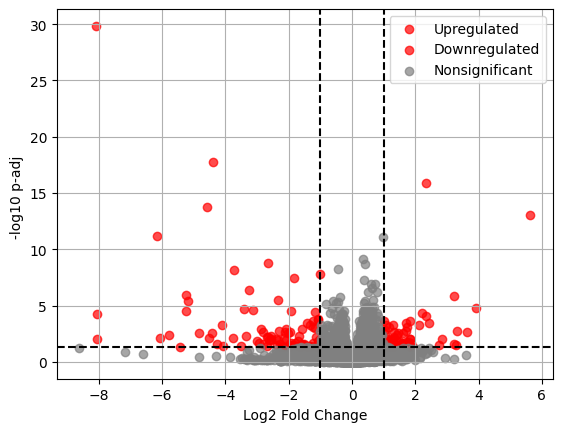

In [40]:
results['significant'] = (results['padj'] < 0.05) & (abs(results['log2FoldChange']) > 1)
results['nonsignificant'] = ~results['significant']

plt.scatter(results.loc[(results['significant']) & (results['log2FoldChange'] > 0), 'log2FoldChange'],
            -np.log10(results.loc[(results['significant']) & (results['log2FoldChange'] > 0), 'padj']),
            color='red', alpha=0.7, label='Upregulated')

# Highlight significant genes (downregulated)
plt.scatter(results.loc[(results['significant']) & (results['log2FoldChange'] < 0), 'log2FoldChange'],
            -np.log10(results.loc[(results['significant']) & (results['log2FoldChange'] < 0), 'padj']),
            color='red', alpha=0.7, label='Downregulated')

plt.scatter(results.loc[(results['nonsignificant']), 'log2FoldChange'],
            -np.log10(results.loc[(results['nonsignificant']), 'padj']),
            color='grey', alpha=0.7, label='Nonsignificant')


plt.xlabel('Log2 Fold Change')
plt.ylabel('-log10 p-adj ')
plt.axhline(y=-np.log10(0.05), color='black', linestyle='--')  # p-value threshold
plt.axvline(x=1, color='black', linestyle='--')  # Log2FC threshold
plt.axvline(x=-1, color='black', linestyle='--')

plt.legend()
# Show plot
plt.grid()
plt.show()

# 3d

In [41]:
sorted_df = result_df.loc[result_df['significant']].sort_values(by='padj', ascending=True)


In [42]:
top50 = sorted_df.iloc[:50]

In [43]:
sorted_df = sorted_df.dropna(subset='log2FoldChange')


In [44]:
sorted_df.to_csv('most_significant.csv')


In [45]:
sorted_df[:50].to_csv('50most-significant.csv')


# 4a

In [46]:
normalized_counts_df = deseq2_norm(deseq_df.transpose().loc[metadata_df.index])[0]


In [47]:
normalized_counts_df = normalized_counts_df.transpose()


In [48]:
normalized_counts_df = normalized_counts_df.loc[sorted_df.index]


In [49]:
log_counts_df = np.log1p(normalized_counts_df)

# Standardize the data using z-score normalization
scaler = StandardScaler()
scaled_counts = scaler.fit_transform(log_counts_df.T).T  # Transpose before and after scaling
scaled_counts_df = pd.DataFrame(scaled_counts, index=log_counts_df.index, columns=log_counts_df.columns)

In [50]:
gene_labels = metadata_df['refinebio_disease']


# 4b

In [51]:
lut = {'healthy': 'green', 'ra non treatment': 'purple'}
row_colors = gene_labels.map(lut)

In [52]:
scaled_counts_df.columns.name = 'Sample'
row_colors.name = 'Sample group'


In [53]:
print(scipy.__version__)

1.14.1


C:\Users\madoe\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
C:\Users\madoe\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 5000x5000 with 0 Axes>

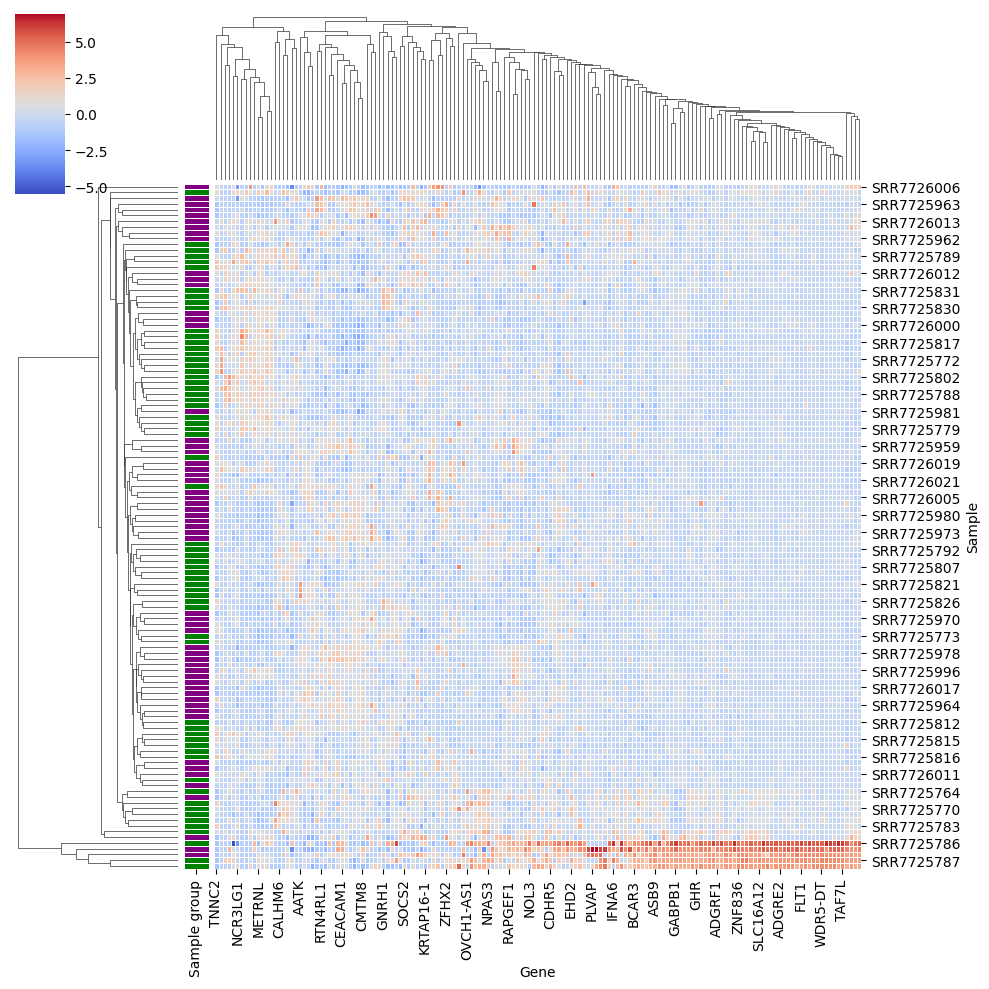

In [54]:
import scipy
plt.figure(figsize=(50, 50))

# Use seaborn to create the heatmap
sns.clustermap(scaled_counts_df.transpose(), row_colors=row_colors, cmap="coolwarm", linewidths=0.5)

# Show the heatmap
plt.show()